Initalisation and declearing functions

In [1]:
import pandas as pd
import numpy as np
import newtonRaphson as NR
import matplotlib.pyplot as plt
import volatility_surface as VLS
import IFD_HW2 as hw2
import xlwings

def quickread():
    excel_file = xlwings.Book("assg4.xlsx")
    sheet = excel_file.sheets["Calibration"]
    daycount = sheet["C10"].value
    spot = sheet["C2"].value
    rf = sheet["C3"].value
    hist_vol = sheet["C4"].value
    q_mat = sheet["C13"].value
    q_strike = sheet["C14"].value
    return daycount,spot,rf, hist_vol, q_mat, q_strike

def quickout(H:pd.DataFrame,vol):
    excel_file = xlwings.Book("assg4.xlsx")
    sheet = excel_file.sheets["Calibration"]
    H = H.copy()
    H.rename_axis("maturities",inplace=True)
    H.columns = ["h0", "h1", "h2", "h3"]
    sheet["G2:K17"].options(pd.DataFrame).value = H
    sheet["C15"].value = vol


# ------------------------------------------------------------------------

def cumStdNorm(d):
    from math import erf,sqrt
    return (1.0+erf(d/sqrt(2.0)))/2.0
#
#---------------------------------------------------------------------------
def BlackScholePricingErr(x, marketCallPrice, strike, maturity, assetPrice, riskFree):
    from math import log,sqrt,exp
#
    d1=(log(assetPrice/strike)+(riskFree+0.5*x[0]**2)*maturity)/(x[0]*sqrt(maturity))
    d2=d1-x[0]*sqrt(maturity)  
    callPrice=assetPrice*cumStdNorm(d1)-strike*exp(-riskFree*maturity)*cumStdNorm(d2)  
    g=[callPrice-marketCallPrice]
#
    return g
# --------------------------------------------------------------------------
def plot_check(x:pd.DataFrame,y:pd.DataFrame,pos):
    plt.plot(x.iloc[:,pos])
    plt.plot(y.iloc[:,pos])

    plt.title("maturity: {0:2f} Year".format(y.columns[pos]))
    plt.xlabel("Price")
    plt.ylabel("Implied Volatility")
    plt.legend(["data points", "trained surface"])
    plt.show
# --------------------------------------------------------------------------


Data Formating and calculated Implied volatility

In [2]:
daycount,spot,rf,hist_vol,q_mat,q_strike = quickread()
data =pd.read_csv("Data.csv")
data = data[data["Mispriced"]==False]
data.drop(["Mispriced"],axis = 1,inplace=True)
data["T"] = data["DaysToMat"]/daycount

params={
    "spot":spot,
    "rf":rf,
    "data":data
}
out = pd.DataFrame(index = data.index, columns = ["EstImpVol", "PrecFlag", "MaxDev"])

# finding implied volatility with newton raphson
for indexval in data.index:
    price = data.loc[indexval,"MarketPrice"]
    strike = data.loc[indexval,"Strike"]
    mat = data.loc[indexval,"T"]
    x, premet, maxdev = NR.newtonRaphson(lambda x : BlackScholePricingErr(x,price, strike, mat, spot, rf), [hist_vol], 1e-6)
    out.loc[indexval,:] = [x[0],premet,maxdev]

data["ImpVol"] = out["EstImpVol"]

In [3]:
#finding H matrix for use in surface
X = VLS.gen_maturity_vol_func_dataset(data["Strike"],data["T"].values,params)
H = VLS.solve_maturity_vol_parms(X,data["ImpVol"])

print(H)


                X0        X1         X2          X3
0.007692  0.189215 -1.581103  22.714288  450.845212
0.030769  0.166362 -1.560704   4.079527  272.659256
0.092308  0.149405 -0.844823  -2.753637  101.232952
0.226923   0.14794 -0.559402  -1.537401   29.383167
0.334615    0.1407 -0.301027   1.034052    1.506265
0.380769  0.150437 -0.391081  -0.040011    5.904403
0.442308  0.149186 -0.369091   -0.09069    6.276655
0.684615  0.150989 -0.257783  -0.202466    2.850701
0.734615  0.153243 -0.266734  -0.250513    3.077028
1.034615  0.151727 -0.201289    0.01938    0.943947
1.084615  0.150976 -0.159325  -0.222308    1.237214
1.384615  0.148029 -0.163131  -0.262987     1.72567
1.734615  0.149226 -0.144991  -0.175323    0.894429
2.461538  0.144576 -0.126477   0.067941     0.18606
3.861538  0.146923 -0.080267  -0.117698    0.293429


Generate surface and check for goodnessfit

Implied Volatility at K = 1300, T = 0.5 = 0.145439


  0%|          | 0/360 [00:00<?, ?it/s]

100%|██████████| 360/360 [00:01<00:00, 327.85it/s]


Max Error= 0.017149180958608984, MSE = 1.4773327553112926e-05


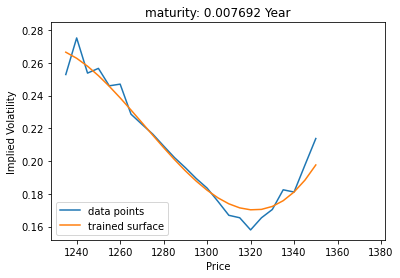

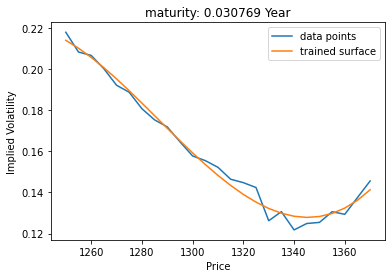

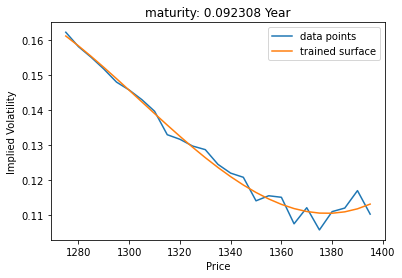

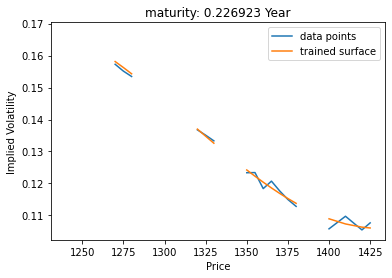

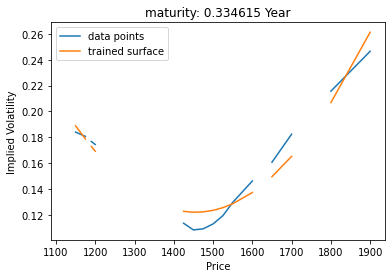

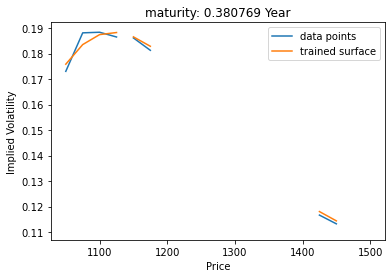

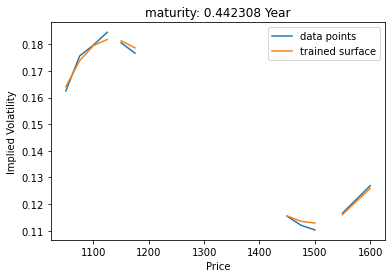

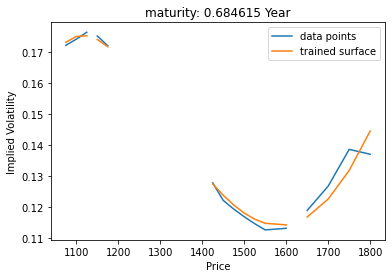

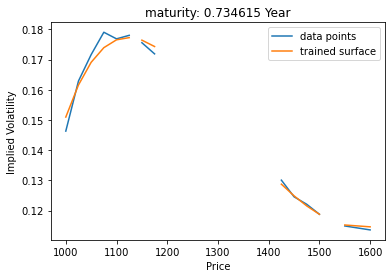

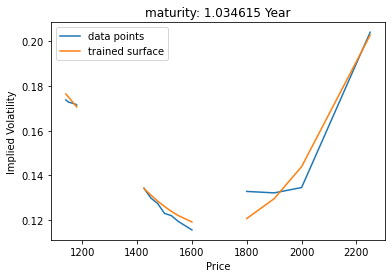

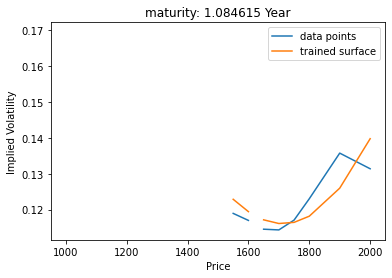

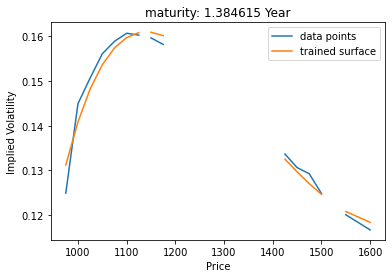

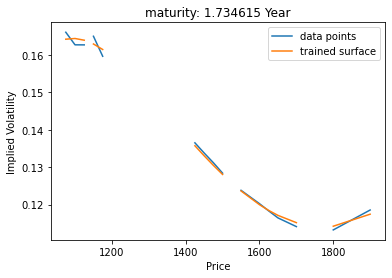

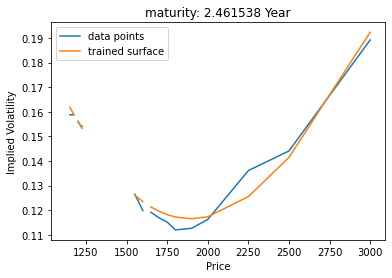

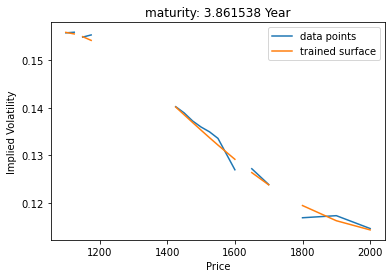

In [4]:
#create vol surface
vol_surface = VLS.CubicSplineSurface(H,params)

t_times = list(set(data["T"]))
t_times.sort()
t_prices = list(set(data["Strike"]))
t_prices.sort()

# query singlee point for excel output
q_vol = vol_surface.eval_imp_vol(q_strike,q_mat)

print("Implied Volatility at K = 1300, T = 0.5 = {:2f}".format(q_vol))

# checks the goodness fit of the surface against all known points (from data)
test_res = vol_surface.check()
error = test_res["EstImpVol"] - test_res["ImpVol"]
# print(error)

#visualise the results
print("Max Error= {}, MSE = {}".format(abs(error).max(),(error**2).mean()))

test_res.drop_duplicates(inplace=True)
t_act = test_res.pivot(index = "Strike", columns = "T", values = "ImpVol")
t_est = test_res.pivot(index = "Strike", columns = "T", values = "EstImpVol")


for i in range(len(t_act.columns)):
    plt.figure(i)
    plot_check(t_act,t_est,i)

quickout(H,q_vol)

realtively well fitting "H" matrix (within our dataset range)

100%|██████████| 15/15 [00:00<00:00, 250.45it/s]


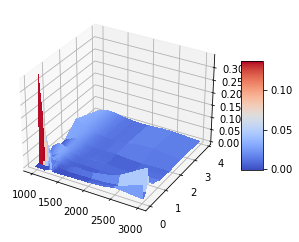

Local Vol Surface near dataset


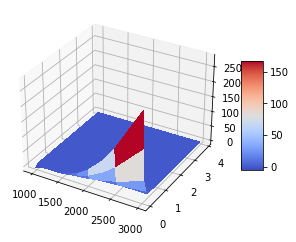

implied Vol Surface near dataset


In [5]:
# visualise the volaitlity surface near the dataset for qualatative inspection
t_times = list(set(data["T"]))
t_prices = list(set(data["Strike"]))

vol_surface.gen_local_vol_surface(t_prices,t_times)

VLS.plot_surface(t_prices,t_times, vol_surface.export_surface('local'))
print("Local Vol Surface near dataset")

VLS.plot_surface(t_prices,t_times, vol_surface.export_surface('implied'))
print("implied Vol Surface near dataset")


**comments** This is still within the range of feasiblilty, but  there are potential isues with extrapolation & "spiky" local volatilties

Option Pricing

  0%|          | 0/101 [00:00<?, ?it/s]c:\Users\ChunMing\anaconda3\envs\OAFdata\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 0/101 [00:00<?, ?it/s]d:\HW4\volatility_surface.py:412: RuntimeWarning: divide by zero encountered in log
  out = np.log(price/(params["spot"]*np.exp(params["rf"]*maturities)))
c:\Users\ChunMing\anaconda3\envs\OAFdata\lib\site-packages\pandas\core\series.py:2591: RuntimeWarning: invalid value encountered in add
  return np.dot(lvals, rvals)
d:\HW4\volatility_surface.py:269: RuntimeWarning: divide by zero encountered in true_divide
  beta = (np.log(spot/price)+(rf+0.5*v**2)*time)/v
100%|██████████| 101/101 [00:00<00:00, 164.75it/s]
d:\HW4\volatility_surface.py:354: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(x, y, z, cmap=matplotlib.cm.get_cmap('coolwarm'),


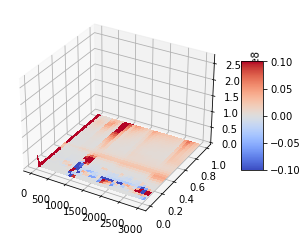

local vol surface


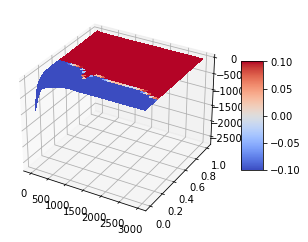

implied vol surface


In [6]:
# get option pricing inputs from excel
jmax,imax,maturity,strike,riskFree,dprice,type,Sko,q=hw2.readfile('ifd_call.xlsx')
dtime = maturity/imax 

# generate the model price-time-grid (setting time precision at 2 dp)
model_prices = np.arange(0,(jmax+1)*dprice, dprice).round(0)
model_times = np.arange(0,(imax+1)*dtime,dtime).round(2) 

# generate and export the surface for all grid points
vol_surface.gen_local_vol_surface(model_prices,model_times,True)
VolData = vol_surface.export_surface('local')
ImpVol = vol_surface.export_surface('implied')

#Visiualise surface
VLS.plot_surface(model_prices,model_times,VolData)
print("local vol surface")
VLS.plot_surface(model_prices,model_times,ImpVol)
print("implied vol surface")

In [7]:
# confirming the nature of consol log warnings
model_times = np.arange(1/100,(imax+1)*1/100,1/100).round(2) 
vol_surface.gen_local_vol_surface(model_prices,model_times,True)

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 197.34it/s]


**Note1** the numerical warnings comes from times being very close or at to 0, they do not appear (as tested above) otherwise and is should not be of concern

**Note2** the large magitude in some localtions significantly skews the visualised surfaces making them appear "flat"

**comments** volatility is very negative from in extrapolated regions (i.e. K << 1000) but don't think this affect our pricing becase
1) the knock out boundary at L = 1000 pevents extensive extrapolation
2) negative values are ignored (as we cannot* find a meaningful square root for our context)

Local Volatility is "Spikey" around and also very large when maturity is small, which can potentially affect the price(?)

100%|██████████| 100/100 [00:01<00:00, 92.03it/s]


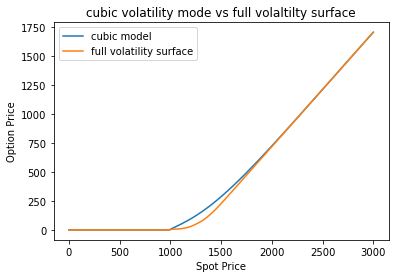

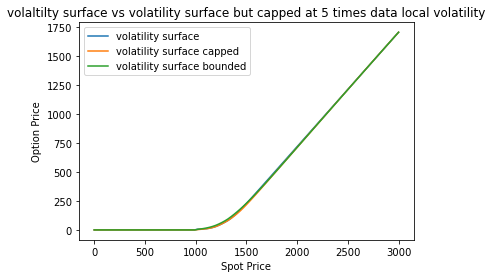

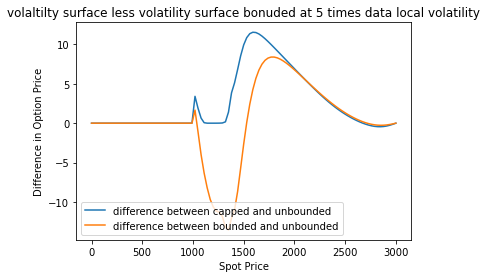

In [8]:
# get IFD pricing methods (mostly from homework 2)

# European KnockOut Call option 
call = hw2.IFDEuropeanKOCall(riskFree,imax,jmax,dprice)
underlying1, option1 = call.price(strike,maturity,Sko,q)

# KnockOut Call using volatility surface 
call_vol_surface = hw2.IFDEuropeanKOCall_VolSurface(riskFree,imax,jmax,dprice,VolData)
underlying2, option2 = call_vol_surface.price(strike,maturity,Sko,q)

max_multiple = 5
max_cap = max_multiple*test_res["EstLocalVol"].max()

min_multiple = 5
min_cap = 1/min_multiple*test_res["EstImpVol"].min()

# KnockOut Call using volatility surface, but with max values capped to limit effects of "spikes"
call_vol_surface_capped = hw2.IFDEuropeanKOCall_BoundedVolSurface(riskFree,imax,jmax,dprice,VolData,max_cap,0)
underlying3, option3 = call_vol_surface_capped.price(strike,maturity,Sko,q)

# KnockOut Call using volatility surface, but fully bounded 
call_vol_surface_bounded = hw2.IFDEuropeanKOCall_BoundedVolSurface(riskFree,imax,jmax,dprice,VolData,max_cap,min_cap)
underlying4, option4 = call_vol_surface_bounded.price(strike, maturity,Sko,q)
#plotting to visualise
plt.figure(1)
plt.plot(underlying1,option1)
plt.plot(underlying2,option2)
plt.xlabel("Spot Price")
plt.ylabel('Option Price')
plt.title("cubic volatility mode vs full volaltilty surface")
plt.legend(["cubic model", "full volatility surface"])

plt.figure(2)
plt.plot(underlying2,option2)
plt.plot(underlying3,option3)
plt.plot(underlying4,option4)
plt.xlabel("Spot Price")
plt.ylabel('Option Price')
plt.title("volaltilty surface vs volatility surface but capped at {} times data local volatility".format(max_multiple))
plt.legend(["volatility surface", "volatility surface capped", "volatility surface bounded"])

plt.figure(3)
plt.plot(underlying2,option2-option3)
plt.plot(underlying4,option2-option4)
plt.xlabel("Spot Price")
plt.ylabel('Difference in Option Price')
plt.title("volaltilty surface less volatility surface bonuded at {} times data local volatility".format(max_multiple))
plt.legend(["difference between capped and unbounded", "difference between bounded and unbounded"])


In [9]:
1/5*test_res.min()

Strike            195.0
T              0.001538
ImpVol         0.021096
EstImpVol      0.021218
EstLocalVol     0.00009
dtype: object

**Comments**: option pricing code from HW2, error is potentially carried forward. 

"spiky" volalitiliy seems to have limtied effect and lead to over pricing

might not also make sense for volatility to neagive, if we were to do the same a force a minimum bound to volatlity, we can see that again effect is limtied 

In [10]:
# export to excel for refernec
hw2.writefile('ifd_call.xlsx',underlying2,option2,jmax)

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:03<00:00, 26.46it/s]


timing experiment to see of the code runs sufficently quickly to be practical

In [11]:
%%timeit

# key code

data =pd.read_csv("Data.csv")
data = data[data["Mispriced"]==False]
data.drop(["Mispriced"],axis = 1,inplace=True)
data["T"] = data["DaysToMat"]/daycount

params={
    "spot":spot,
    "rf":rf,
    "data":data
}
out = pd.DataFrame(index = data.index, columns = ["EstImpVol", "PrecFlag", "MaxDev"])

for indexval in data.index:
    price = data.loc[indexval,"MarketPrice"]
    strike = data.loc[indexval,"Strike"]
    mat = data.loc[indexval,"T"]
    x, premet, maxdev = NR.newtonRaphson(lambda x : BlackScholePricingErr(x,price, strike, mat, spot, rf), [hist_vol], 1e-6)
    out.loc[indexval,:] = [x[0],premet,maxdev]

data["ImpVol"] = out["EstImpVol"]

X2 = VLS.gen_maturity_vol_func_dataset(data["Strike"],data["T"].values,params)
H2 = VLS.solve_maturity_vol_parms(X,data["ImpVol"])

vs2 = VLS.CubicSplineSurface(H,params)
model_prices = np.arange(0,(jmax+1)*dprice, dprice).round(0)
model_times = np.arange(0,(imax+1)*dtime,dtime).round(2) 

vs2.gen_local_vol_surface(model_prices,model_times,True)
vol_data = vs2.export_surface()

call_vol_surface = hw2.IFDEuropeanKOCall_VolSurface(riskFree,imax,jmax,dprice,vol_data)
underlying2, option2 = call_vol_surface.price(strike,maturity,Sko,q)


  0%|          | 0/101 [00:00<?, ?it/s]c:\Users\ChunMing\anaconda3\envs\OAFdata\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 0/101 [00:00<?, ?it/s]d:\HW4\volatility_surface.py:412: RuntimeWarning: divide by zero encountered in log
  out = np.log(price/(params["spot"]*np.exp(params["rf"]*maturities)))
c:\Users\ChunMing\anaconda3\envs\OAFdata\lib\site-packages\pandas\core\series.py:2591: RuntimeWarning: invalid value encountered in add
  return np.dot(lvals, rvals)
d:\HW4\volatility_surface.py:269: RuntimeWarning: divide by zero encountered in true_divide
  beta = (np.log(spot/price)+(rf+0.5*v**2)*time)/v
  0%|          | 0/101 [00:00<?, ?it/s]c:\Users\ChunMing\anaconda3\envs\OAFdata\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 0/101 [00:00<?, ?i

2.87 s ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Full code that goes from raw data to option price runs ~ 3 seconds, no timing issues.